In [38]:
cd MOEoformer

/home/wjddms2216/eun/MOEoformer


In [16]:
import nibabel as nib
from matplotlib import pyplot as plt
import os

test_image_t2 = nib.load('predictions/moeformer_image_patient_6.nii.gz').get_fdata()
test_label_t2 = nib.load('predictions/moeformer_label_patient_6.nii.gz').get_fdata()
test_seg= nib.load('predictions/moeformer_logit_patient_6.nii.gz').get_fdata()





In [61]:
test_image_t2.shape

(4, 240, 240, 155)

In [62]:
test_seg.shape

(3, 240, 240, 155)

In [63]:
test_label_t2.shape

(3, 240, 240, 155)

In [9]:
! pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.9 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 226 kB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 38.6 MB 104 kB/s  eta 0:00:01
     |████████████████████████████████| 313 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 6.2 MB/s eta 0:00:01
  distutils: /home/wjddms2216/.local/lib/python3.9/site-packages
  sysconfig: /home/wjddms2216/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None


(4, 240, 240, 155)


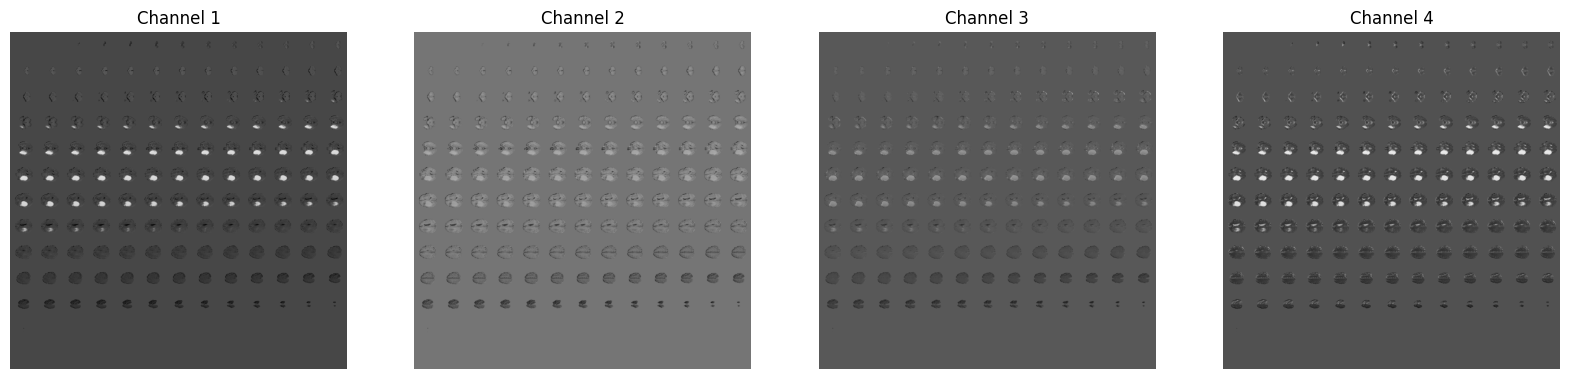

In [10]:
from skimage.util import montage
from skimage.transform import rotate
import numpy as np
import matplotlib.pyplot as plt

# test_image_t2의 shape 출력
print(test_image_t2.shape)  # (4, 240, 240, 155)

# test_image_t2의 각 채널(4개)을 개별적으로 처리하여 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 20))

for i in range(4):
    # 각 채널을 (240, 240, 155) 형식에서 (155, 240, 240) 형식으로 변환
    channel_image = np.transpose(test_image_t2[i], (2, 0, 1))
    
    # montage를 통해 여러 이미지를 하나의 이미지로 시각화
    montage_image = montage(channel_image)
    
    # subplot에 이미지 표시
    axes[i].imshow(montage_image, cmap='gray')
    axes[i].set_title(f'Channel {i+1}')
    axes[i].axis('off')

plt.show()


(3, 240, 240, 155)


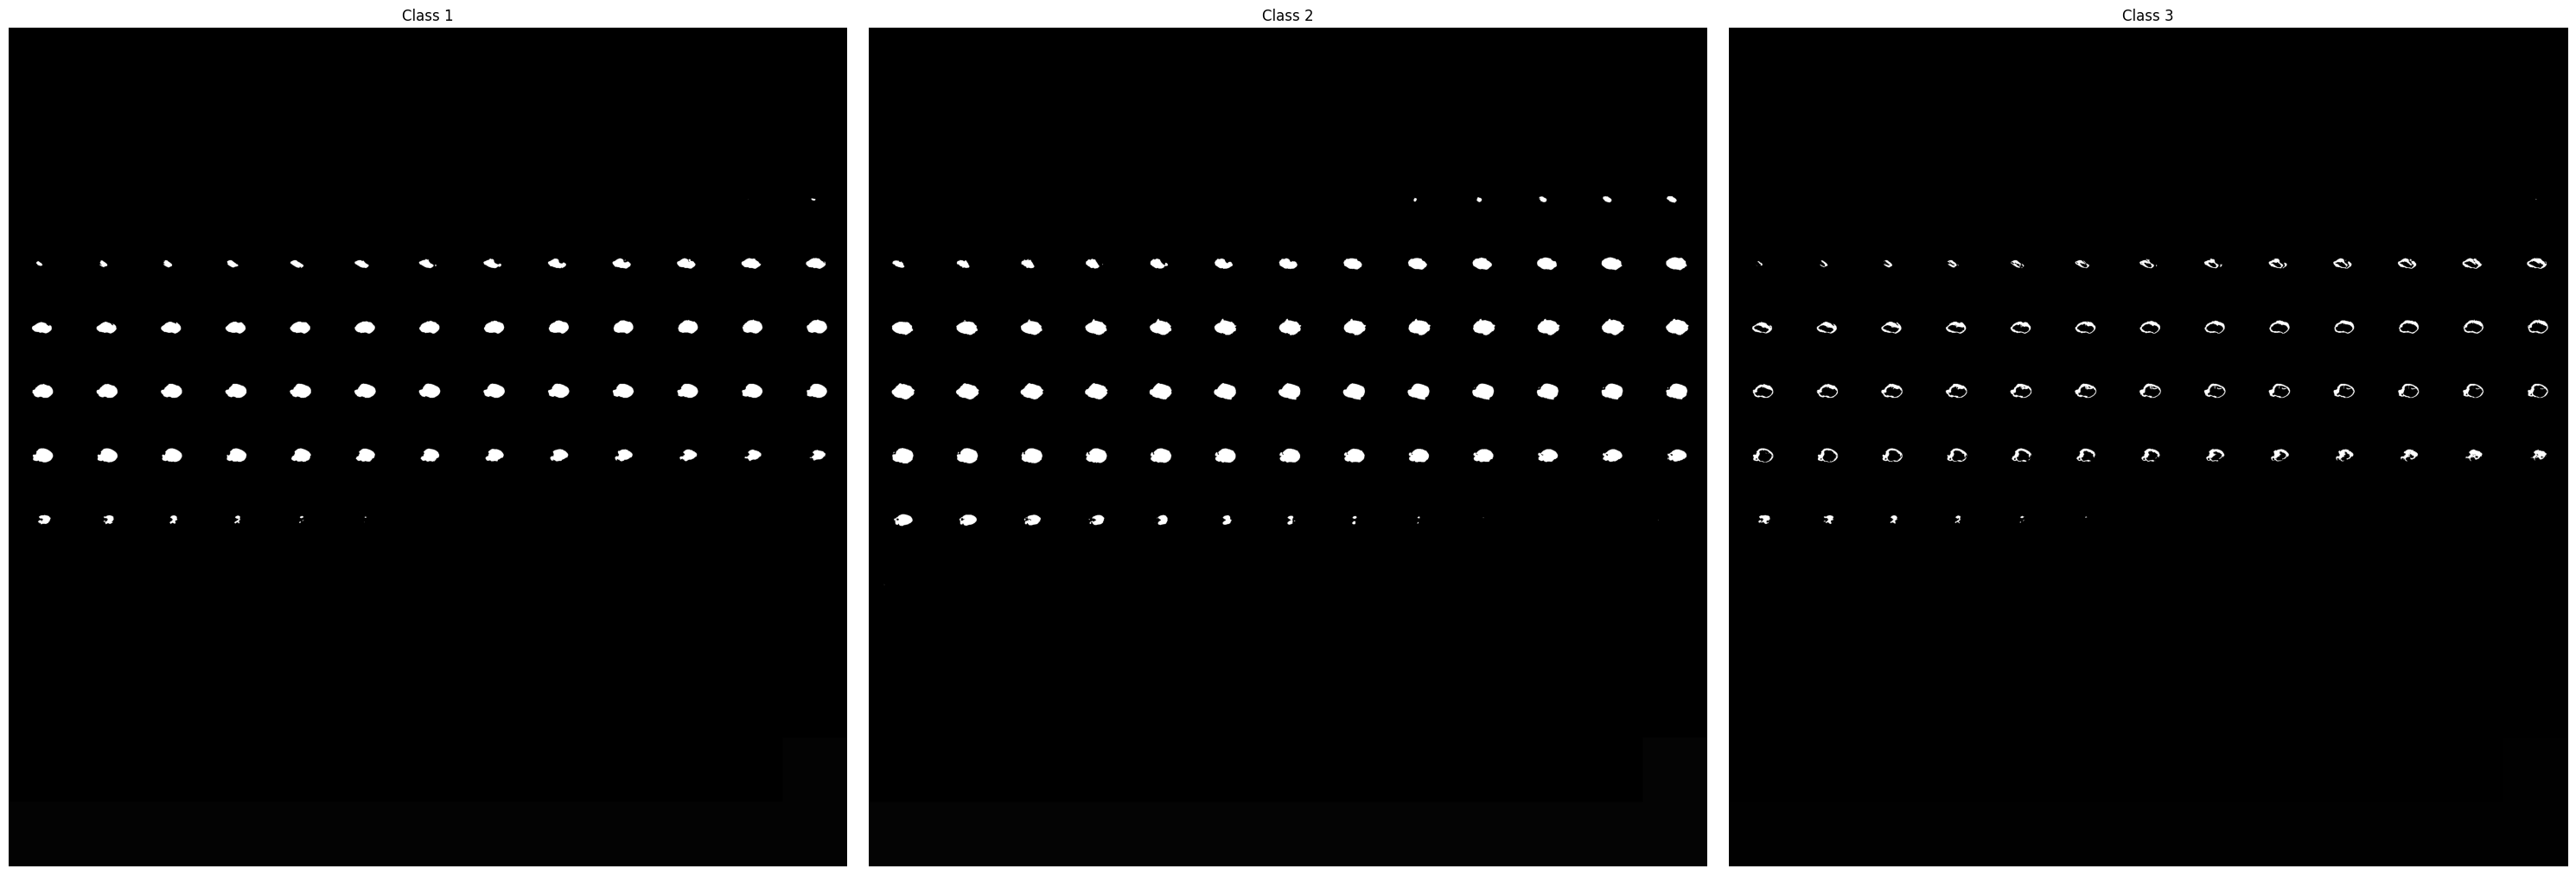

In [11]:
from skimage.util import montage
import numpy as np
import matplotlib.pyplot as plt

# test_seg의 shape 출력
print(test_seg.shape)  # (3, 240, 240, 155)

# 각 클래스에 대한 시각화를 위해 subplot 생성
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for i in range(3):
    # 각 클래스 이미지를 (240, 240, 155) 형식에서 (155, 240, 240) 형식으로 변환
    class_image = np.transpose(test_seg[i], (2, 0, 1))
    
    # montage를 통해 여러 이미지를 하나의 이미지로 시각화
    montage_image = montage(class_image)
    
    # subplot에 이미지 표시
    axes[i].imshow(montage_image, cmap='gray')
    axes[i].set_title(f'Class {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


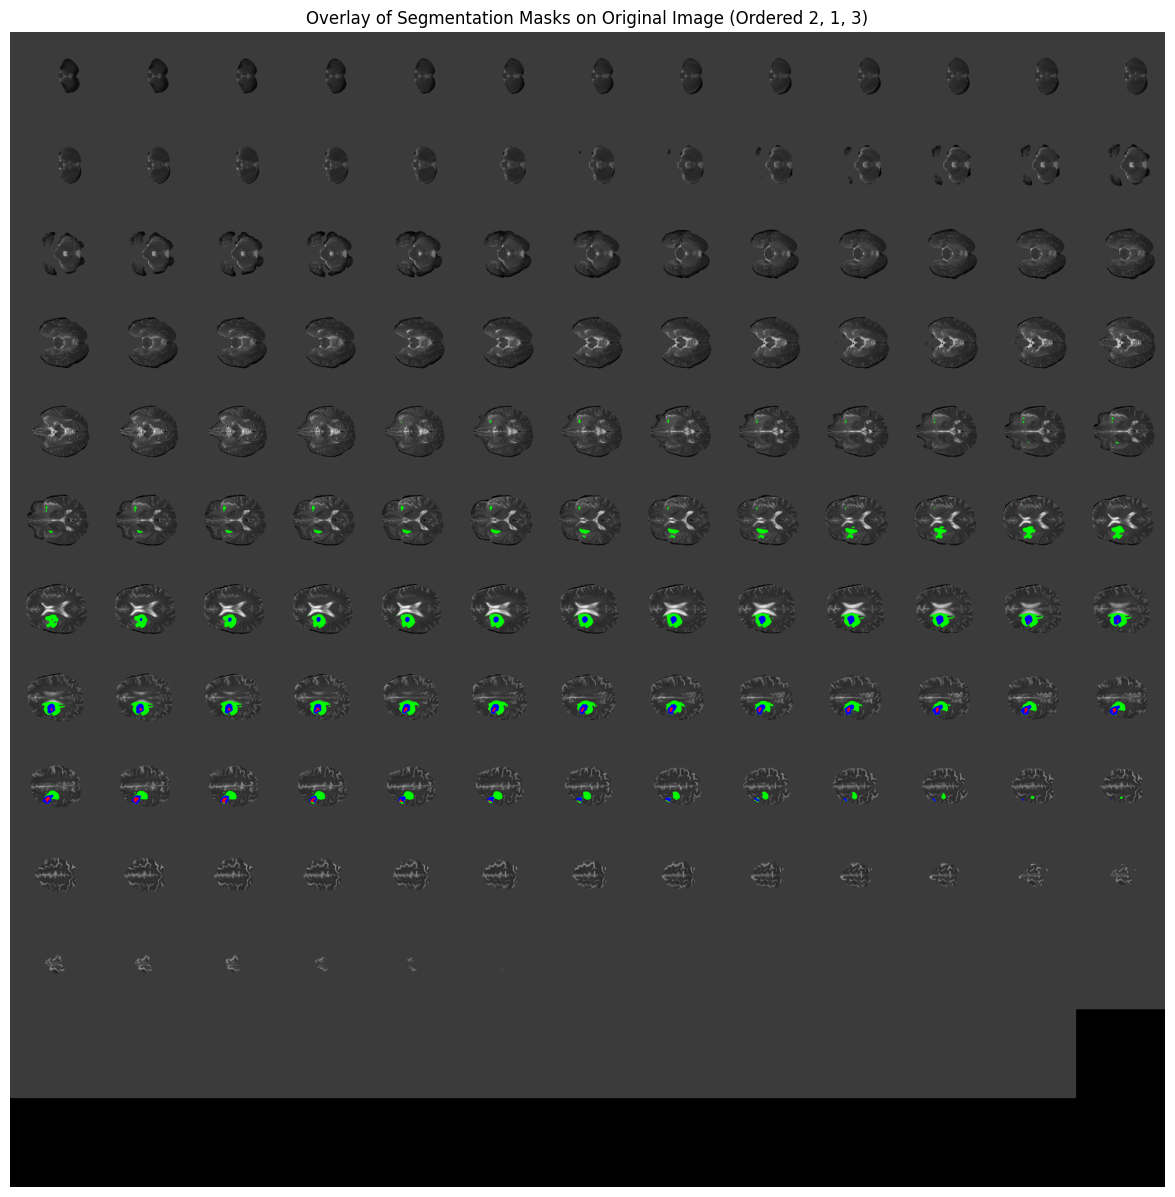

In [65]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import montage

# 이미지와 세그멘테이션 데이터를 로드
test_image_t2 = nib.load('swin__unetr/predictions/outputencoder_image_0.nii.gz').get_fdata()  # Shape: (4, 240, 240, 155)
test_seg = nib.load('swin__unetr/predictions/outputencoder_logit_0.nii.gz').get_fdata()  # Shape: (3, 240, 240, 155)

# 사용할 모달리티 인덱스 (0~3 중 하나를 선택)
modality_index = 3

# 각 클래스에 대한 색상 설정 (Red, Green, Blue)
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

# 슬라이스 수
num_slices = test_image_t2.shape[3]

# 원본 이미지를 (240, 240, 155) 형식에서 (155, 240, 240) 형식으로 변환
background_images = np.transpose(test_image_t2[modality_index], (2, 0, 1))

# 각 클래스 마스크를 시각화하기 위해 (240, 240, 155) 형식에서 (155, 240, 240) 형식으로 변환
class_masks = [np.transpose(test_seg[i], (2, 0, 1)) for i in range(3)]

# 원본 이미지의 montage 생성
background_montage = montage(background_images)

# 원본 이미지 정규화
background_montage = (background_montage - background_montage.min()) / (background_montage.max() - background_montage.min())

# 각 클래스 마스크의 montage 생성 및 색상 적용
colored_masks = []
for i in range(3):
    class_montage = montage(class_masks[i])
    colored_mask = np.zeros((*class_montage.shape, 3))  # RGB 채널을 위한 빈 배열 생성
    for c in range(3):
        colored_mask[:, :, c] = class_montage * colors[i][c]
    colored_masks.append(colored_mask)

# 원하는 순서로 마스크 재정렬 (class 2, 1, 3 순서)
ordered_masks = [colored_masks[1], colored_masks[0], colored_masks[2]]

# 원본 이미지와 클래스 마스크를 오버레이
overlay_image = np.stack([background_montage] * 3, axis=-1)  # RGB 형식으로 변환 (회색조)

for colored_mask in ordered_masks:
    # 마스크가 있는 부분에만 색상을 적용
    mask = np.any(colored_mask > 0, axis=-1)
    overlay_image[mask] = colored_mask[mask]

# 시각화
plt.figure(figsize=(15, 15))
plt.imshow(overlay_image)
plt.title('Overlay of Segmentation Masks on Original Image (Ordered 2, 1, 3)')
plt.axis('off')
plt.show()


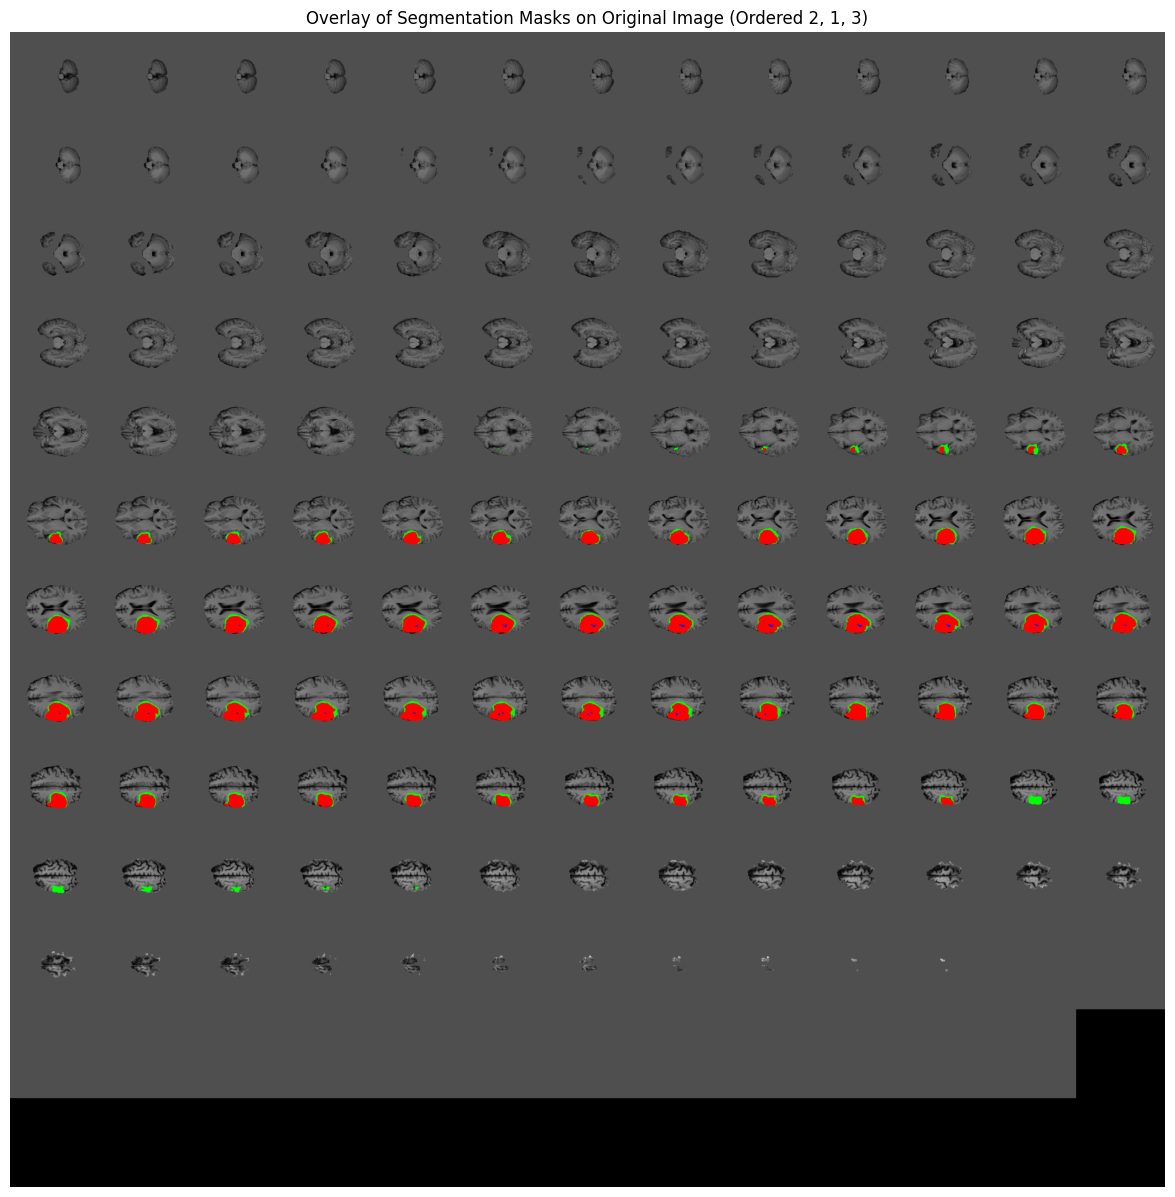

In [30]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import montage

# 이미지와 세그멘테이션 데이터를 로드
test_image_t2 = nib.load('predictions/nestedformer_image_patient_6.nii.gz').get_fdata()
test_label= nib.load('predictions/nestedformer_label_patient_6.nii.gz').get_fdata()

# 사용할 모달리티 인덱스 (0~3 중 하나를 선택)
modality_index = 1

# 각 클래스에 대한 색상 설정 (Red, Green, Blue)
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

# 슬라이스 수
num_slices = test_image_t2.shape[3]

# 원본 이미지를 (240, 240, 155) 형식에서 (155, 240, 240) 형식으로 변환
background_images = np.transpose(test_image_t2[modality_index], (2, 0, 1))

# 각 클래스 마스크를 시각화하기 위해 (240, 240, 155) 형식에서 (155, 240, 240) 형식으로 변환
class_masks = [np.transpose(test_label[i], (2, 0, 1)) for i in range(3)]

# 원본 이미지의 montage 생성
background_montage = montage(background_images)

# 원본 이미지 정규화
background_montage = (background_montage - background_montage.min()) / (background_montage.max() - background_montage.min())

# 각 클래스 마스크의 montage 생성 및 색상 적용
colored_masks = []
for i in range(3):
    class_montage = montage(class_masks[i])
    colored_mask = np.zeros((*class_montage.shape, 3))  # RGB 채널을 위한 빈 배열 생성
    for c in range(3):
        colored_mask[:, :, c] = class_montage * colors[i][c]
    colored_masks.append(colored_mask)

# 원하는 순서로 마스크 재정렬 (class 2, 1, 3 순서)
ordered_masks = [colored_masks[1], colored_masks[0], colored_masks[2]]

# 원본 이미지와 클래스 마스크를 오버레이
overlay_image = np.stack([background_montage] * 3, axis=-1)  # RGB 형식으로 변환 (회색조)

for colored_mask in ordered_masks:
    # 마스크가 있는 부분에만 색상을 적용
    mask = np.any(colored_mask > 0, axis=-1)
    overlay_image[mask] = colored_mask[mask]

# 시각화
plt.figure(figsize=(15, 15))
plt.imshow(overlay_image)
plt.title('Overlay of Segmentation Masks on Original Image (Ordered 2, 1, 3)')
plt.axis('off')
plt.show()

## Visualization

In [39]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 이미지와 세그멘테이션 데이터를 로드
test_image_t2 = nib.load('predictions/moeformer_image_patient_6.nii.gz').get_fdata()
test_label_t2 = nib.load('predictions/moeformer_label_patient_6.nii.gz').get_fdata()
test_seg= nib.load('predictions/moeformer_logit_patient_6.nii.gz').get_fdata()

# 사용할 모달리티 인덱스 (0~3 중 하나를 선택)
modality_index = 3

# 각 클래스에 대한 색상 설정 (Red, Green, Blue)
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

# 특정 슬라이스 번호 지정 (예: 75번 슬라이스)
slice_index = 98

# 원본 이미지 슬라이스 추출
background_slice = test_image_t2[modality_index, :, :, slice_index]

# 각 클래스 마스크 슬라이스 추출
class_slices = [test_seg[i, :, :, slice_index] for i in range(3)]
true_class_slices = [test_label_t2[i, :, :, slice_index] for i in range(3)]  # 정답 레이블 슬라이스

# 원본 이미지 정규화 (뇌를 제외한 부분이 검은색이 되도록)
min_val = np.min(background_slice)
max_val = np.max(background_slice)
background_slice_normalized = (background_slice - min_val) / (max_val - min_val)
background_slice_normalized[background_slice_normalized < 0.1] = 0  # 임계값 이하인 부분을 0으로 설정

# 각 클래스 마스크에 색상 적용
colored_masks = []
for i in range(3):
    colored_mask = np.zeros((*class_slices[i].shape, 3))  # RGB 채널을 위한 빈 배열 생성
    for c in range(3):
        colored_mask[:, :, c] = class_slices[i] * colors[i][c]
    colored_masks.append(colored_mask)

# 정답 레이블에 색상 적용
true_colored_masks = []
for i in range(3):
    true_colored_mask = np.zeros((*true_class_slices[i].shape, 3))  # RGB 채널을 위한 빈 배열 생성
    for c in range(3):
        true_colored_mask[:, :, c] = true_class_slices[i] * colors[i][c]
    true_colored_masks.append(true_colored_mask)

# 원하는 순서로 마스크 재정렬 (class 2, 1, 3 순서)
ordered_masks = [colored_masks[1], colored_masks[0], colored_masks[2]]
ordered_true_masks = [true_colored_masks[1], true_colored_masks[0], true_colored_masks[2]]

# 원본 이미지와 클래스 마스크를 오버레이
overlay_image_pred = np.stack([background_slice_normalized] * 3, axis=-1)  # RGB 형식으로 변환 (회색조)
overlay_image_true = np.stack([background_slice_normalized] * 3, axis=-1)  # RGB 형식으로 변환 (회색조)

for colored_mask in ordered_masks:
    # 마스크가 있는 부분에만 색상을 적용
    mask = np.any(colored_mask > 0, axis=-1)
    overlay_image_pred[mask] = colored_mask[mask]

for true_colored_mask in ordered_true_masks:
    # 마스크가 있는 부분에만 색상을 적용
    mask = np.any(true_colored_mask > 0, axis=-1)
    overlay_image_true[mask] = true_colored_mask[mask]

# 원본 슬라이스와 오버레이 이미지 모두 시각화
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# 원본 슬라이스
axes[0].imshow(background_slice_normalized, cmap='gray')
axes[0].set_title(f'Original Image (Slice {slice_index})')
axes[0].axis('off')

# 예측 오버레이 이미지
axes[1].imshow(overlay_image_pred)
axes[1].set_title(f'Predicted Segmentation Masks (Slice {slice_index})')
axes[1].axis('off')

# 정답 오버레이 이미지
axes[2].imshow(overlay_image_true)
axes[2].set_title(f'True Segmentation Masks (Slice {slice_index})')
axes[2].axis('off')

plt.show()


IndexError: boolean index did not match indexed array along axis 1; size of axis is 240 but size of corresponding boolean axis is 155